<a href="https://colab.research.google.com/github/PAULAANDREACAS/MLP-FCN/blob/main/proyectofinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DEEP LEARNING**

**UNIVERSIDAD MILITAR NUEVA GRANADA**

**PERCEPTRON MULTICAPA**

Ingeniería en Telecomunicaciones

In [ ]:
# Carga de librerías
!pip install -q keras-tuner
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
import keras_tuner as kt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import RandomSearch
from IPython import get_ipython
from IPython.display import display
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset

CIFAR-10

Cantidad de imágenes: 60,000

Tamaño de las imágenes: 32x32 píxeles (imágenes a color)

Cantidad de clases: 10 categorías de objetos

Etiquetas (clases):
0 - avión ✈️
1 - automóvil 🚗
2 - pájaro 🐦
3 - gato 🐱
4 - ciervo 🦌
5 - perro 🐶
6 - rana 🐸
7 - caballo 🐴
8 - barco ⛵
9 - camión 🚛

In [ ]:
# Cargar dataset (CIFAR-10 en este caso)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = tf.image.resize(x_train, [28, 28])
x_test = tf.image.resize(x_test, [28, 28])

x_train = x_train.numpy().reshape(x_train.shape[0], 28, 28, 3) # Keep 3 color channels
x_test = x_test.numpy().reshape(x_test.shape[0], 28, 28, 3)   # Keep 3 color channels

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:

# Normalizar los valores de píxeles entre 0 y 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [ ]:
# One-hot encoding de las etiquetas
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Separar un subconjunto de validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

**Labels**

In [ ]:

class_names = ["avión", "automóvil", "pájaro", "gato", "ciervo", "perro", "rana", "caballo", "barco", "camión"]

# Modelo

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 3)))

    # Primera capa oculta
    model.add(Dense(hp.Int('dense1_units', min_value=256, max_value=1024, step=128)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    # Segunda capa oculta
    model.add(Dense(hp.Int('dense2_units', min_value=256, max_value=1024, step=128)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    # Tercera capa oculta
    model.add(Dense(hp.Int('dense3_units', min_value=128, max_value=512, step=64)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    # Capa de salida
    model.add(Dense(10, activation='softmax'))


    model.compile(optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp.Float('learning_rate', min_value=0.00005, max_value=0.001, sampling='LOG')),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Hiperparámetros

In [ ]:
# Configuración del tuner
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=20, executions_per_trial=1, directory='tuner_results', project_name='cifar10_tuning')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


# Búsqueda de los mejores hiperparámetros
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Mostrar los valores óptimos encontrados
print("Mejores hiperparámetros encontrados:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

modelo = build_model(best_hps)


Trial 20 Complete [00h 03m 18s]
val_accuracy: 0.5012999773025513

Best val_accuracy So Far: 0.5228999853134155
Total elapsed time: 01h 35m 14s
Mejores hiperparámetros encontrados:
dense1_units: 896
dense2_units: 384
dense3_units: 320
learning_rate: 0.0005882912146848821


# Entrenamiento

In [ ]:
# Entrenar el modelo
history=modelo.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.6699 - loss: 0.9367 - val_accuracy: 0.5935 - val_loss: 1.1827 - learning_rate: 3.6768e-05
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.6736 - loss: 0.9220 - val_accuracy: 0.5921 - val_loss: 1.1849 - learning_rate: 3.6768e-05
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.6742 - loss: 0.9236 - val_accuracy: 0.5932 - val_loss: 1.1868 - learning_rate: 3.6768e-05
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.6775 - loss: 0.9122 - val_accuracy: 0.5930 - val_loss: 1.1809 - learning_rate: 3.6768e-05
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.6725 - loss: 0.9092 - val_accuracy: 0.5942 - val_loss: 1.1830 - learning_rate: 3.6768e-05
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6744 - loss: 0.9053 - val_accuracy: 0.5932 - val_loss: 1.1851 - learning_rate: 3.6768e-05
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

In [ ]:
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 896)                 │       2,108,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 896)                 │           3,584 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 384)                 │         344,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 320)                 │         123,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 320)                 │           1,280 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           3,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,750,240 (29.56 MB)

 Trainable params: 2,582,346 (9.85 MB)

 Non-trainable params: 3,200 (12.50 KB)

 Optimizer params: 5,164,694 (19.70 MB)

# Evolución del algoritmo

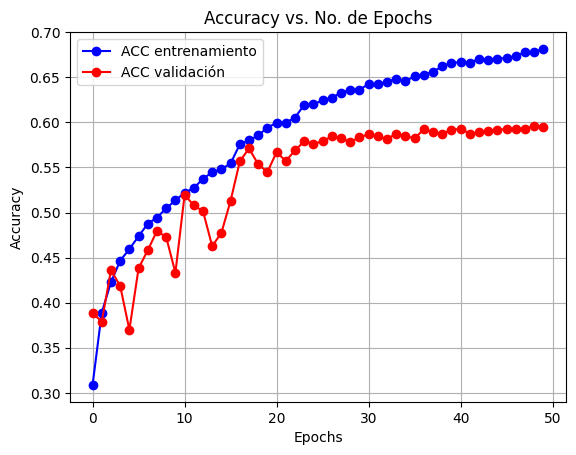

In [ ]:


# Datos
val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
epochs = range(len(train_acc))

# Graficar ambas curvas en la misma figura
plt.plot(epochs, train_acc, 'bo-', label='ACC entrenamiento')  # 'bo-' indica puntos azules con línea
plt.plot(epochs, val_acc, 'ro-', label='ACC validación')  # 'ro-' indica puntos rojos con línea
plt.title('Accuracy vs. No. de Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Mostrar la gráfica
plt.show()



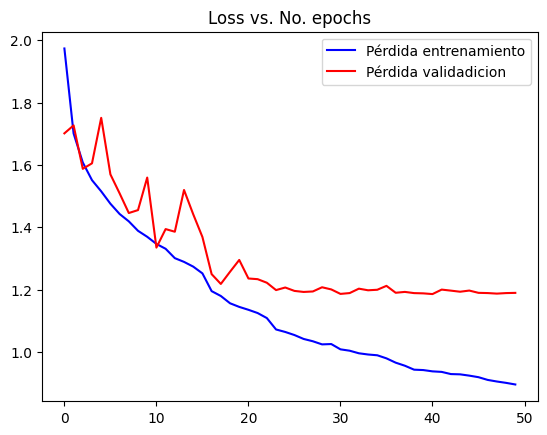

In [ ]:
# Gráfica de Loss
loss = history.history['loss']
epochs = range(len(loss))
val_loss  = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida validadicion')
plt.title('Loss vs. No. epochs')
plt.legend()
plt.show()

## **Prueba del modelo**

In [ ]:
# Función para predecir con nombre de la imagen
def predecir_imagen(imagen):
    imagen = np.expand_dims(imagen, axis=0)
    prediccion = modelo.predict(imagen)
    clase_predicha = np.argmax(prediccion)
    return class_names[clase_predicha]
def probar_modelo(x_test, y_test, num_muestras=5):
    indices = np.random.choice(len(x_test), num_muestras, replace=False)
    for idx in indices:
        imagen = x_test[idx]
        nombre_real = class_names[np.argmax(y_test[idx])]
        nombre_predicho = predecir_imagen(imagen)
        plt.figure(figsize=(2,2))
        plt.imshow(imagen)
        plt.title(f"Real: {nombre_real}\nPredicho: {nombre_predicho}")
        plt.axis('off')
        plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5909 - loss: 1.1793


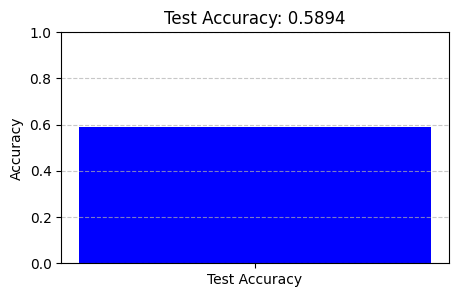

In [ ]:
test_loss, test_accuracy = modelo.evaluate(x_test, y_test)

# Graficar Test Accuracy
plt.figure(figsize=(5, 3))
plt.bar(['Test Accuracy'], [test_accuracy], color='blue')

# Configuración de la gráfica
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Asegurar que el eje Y vaya de 0 a 1
plt.title(f'Test Accuracy: {test_accuracy:.4f}')
plt.grid(axis='y', linestyle='--', alpha=0.7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


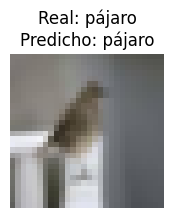

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


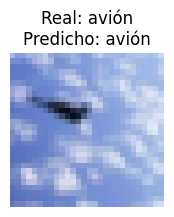

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


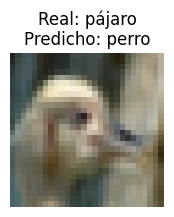

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


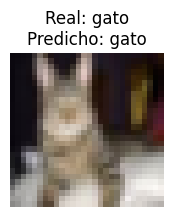

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


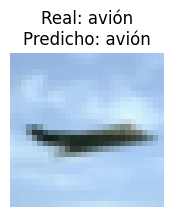

In [18]:
# Probar el modelo con algunas imágenes-(accuracy)
probar_modelo(x_test, y_test)
